In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
import time
import pickle
from itertools import product
from functools import reduce
import numba
from numba import jit
import json

sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
from utils.distributions import Normal, Categorical, cross, expectation
import vanilla_BMPS
import metacontroller
import hierarchical
#from utils.mouselab_metacontroller import MouselabMeta
from utils.mouselab_VAR import MouselabVar
from utils.mouselab_metacontroller import MouselabMeta
import utils.mouselab 
import utils.experiment_creation
from utils.exact import solve

### Define environment and train metacontroller and hierarchical strategy discovery

In [2]:
SWITCH_COST = 0 # Cost of switching goals
HIGH_COST = 10 # Cost of computing a goal
LOW_COST = 10 # Cost of computing a low level node
SEED = 0 # Fixes generated environments for training
COST_FUNC = "Basic"
assert COST_FUNC in ["Basic", "Hierarchical", "Actionweight", "Novpi", "Proportional", "Independentweight"]

BO_RESTARTS = 10
BO_STEPS = 100
EVAL_EPISODES = 100

In [3]:
TREE = [[1, 16, 31, 46], [2, 3, 4, 5], [6], [6], [7], [7], [8], [8], [9, 10, 11, 12], [13], [13], [14], [14], [15], [15], [], [17, 18, 19, 20], [21], [21], [22], [22], [23], [23], [24, 25, 26, 27], [28], [28], [29], [29], [30], [30], [], [32, 33, 34, 35], [36], [36], [37], [37], [38], [38], [39, 40, 41, 42], [43], [43], [44], [44], [45], [45], [], [47, 48, 49, 50], [51], [51], [52], [52], [53], [53], [54, 55, 56, 57], [58], [58], [59], [59], [60], [60], []]
d0 = Categorical([0])
dr = Categorical([-1500, 0], probs=[0.1, 0.9])
di = Categorical([-10, -5, 5, 10])
#dg = Categorical([-50, -25, 25, 50])
dg = Categorical([0, 25, 75, 100])
node_types = [di, d0, di, di, di, di, di, di, dr, di, di, di, di, di, di, dg, d0, di, di, di, di, di, di, dr, di, di, di, di, di, di, dg, d0, di, di, di, di, di, di, dr, di, di, di, di, di, di, dg, d0, di, di, di, di, di, di, dr, di, di, di, di, di, di, dg]
#node_types = [di, dr, di, di, di, di, di, di, di, di, di, di, di, di, di, dg, dr, di, di, di, di, di, di, di, di, di, di, di, di, di, dg, dr, di, di, di, di, di, di, di, di, di, di, di, di, di, dg, dr, di, di, di, di, di, di, di, di, di, di, di, di, di, dg]

INIT = tuple([r for r in node_types])

print(len(TREE))
print(len(node_types))
GOAL_NODES = sum([int(el == []) for el in TREE])
LOW_NODES = int((len(TREE)-1)/GOAL_NODES)

print("Goal nodes", GOAL_NODES, "low nodes", LOW_NODES)

env = MouselabMeta(TREE, INIT)
print(env._term_reward())

61
61
Goal nodes 4 low nodes 15
-100.0


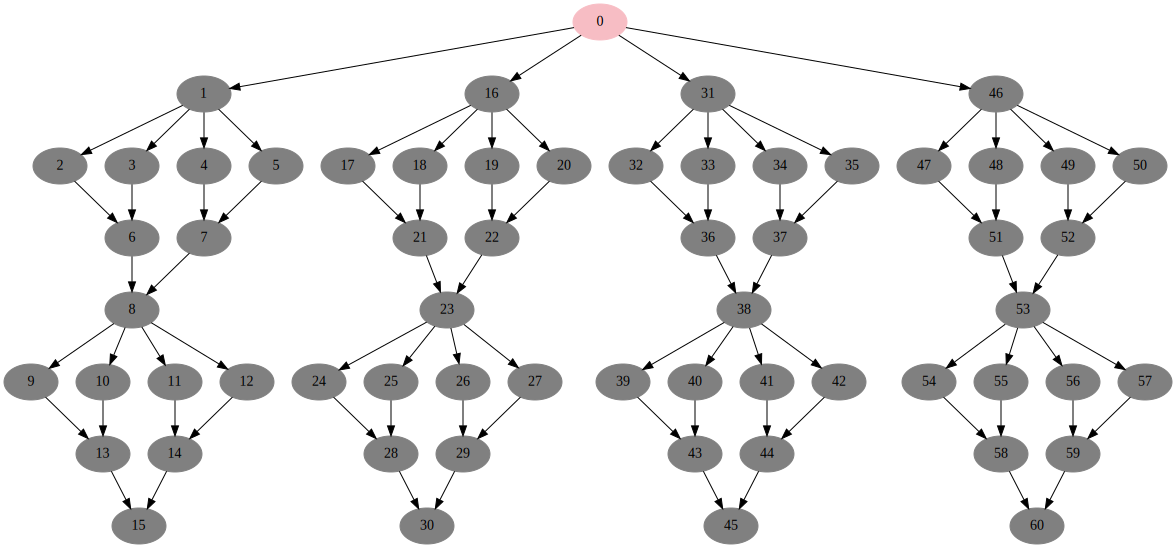

In [47]:
env._render()

In [48]:
# Meta disabled
W_disabled, time_disabled = metacontroller.optimize(TREE=TREE, INIT=INIT, LOW_COST=LOW_COST, HIGH_COST=HIGH_COST, SWITCH_COST=SWITCH_COST, SEED=SEED, low_nodes=LOW_NODES, goal_nodes=GOAL_NODES, samples=BO_RESTARTS, iterations=BO_STEPS, evaluated_episodes=EVAL_EPISODES, disable_meta=True, cost_function=COST_FUNC)

rewards_disabled, actions_disabled = metacontroller.eval(W_disabled, n=500, TREE=TREE, INIT=INIT, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, SWITCH_COST=SWITCH_COST, SEED=SEED+1000, disable_meta=True, cost_function=COST_FUNC) # -11, -30

Testing weights: [ 0.12696983  0.37301223 12.94059693  0.9195404   2.387063  ]
Average reward -100.0
Testing weights: [0.26047601 0.12944068 3.04718126 0.86154929 2.20339367]
Average reward -100.0
Testing weights: [0.33622174 0.35205354 1.85777947 0.34352588 3.10655308]
Average reward -90.25
Testing weights: [0.45137647 0.2288873  9.26596405 0.17091717 2.24210099]
Average reward -86.85
Testing weights: [0.12310214 0.59478359 5.76622912 0.64166617 2.78777596]
Average reward -100.0
Testing weights: [ 0.5430262   0.13755356 14.78620235  0.27459243  1.59959279]
Average reward -87.15
Testing weights: [ 0.09973676  0.56065718 13.07652576  0.61937849  1.74931631]
Average reward -87.15
Testing weights: [0.01654451 0.13876812 2.19992457 0.67239782 3.44963677]
Average reward -100.0
Testing weights: [0.4813845  0.09446113 8.92543536 0.80998032 1.13304529]
Average reward -87.15
Testing weights: [0.49730633 0.13409924 7.68436224 0.54475875 1.08965989]
Average reward -87.15
Testing weights: [0.42040

In [49]:
W_meta, time_meta = metacontroller.optimize(TREE=TREE, INIT=INIT, LOW_COST=LOW_COST, HIGH_COST=HIGH_COST, SWITCH_COST=SWITCH_COST, SEED=SEED, low_nodes=LOW_NODES, goal_nodes=GOAL_NODES, samples=BO_RESTARTS, iterations=BO_STEPS, evaluated_episodes=EVAL_EPISODES, disable_meta=False, cost_function=COST_FUNC)

rewards_meta, actions_meta = metacontroller.eval(W_meta, n=500, TREE=TREE, INIT=INIT, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, SWITCH_COST=SWITCH_COST, SEED=SEED+1000, disable_meta=False, cost_function=COST_FUNC) #31

# Best performance on initial high risk ~17

Testing weights: [ 0.12696983  0.37301223 12.94059693  0.9195404   2.387063  ]
Average reward 38.7
Testing weights: [0.26047601 0.12944068 3.04718126 0.86154929 2.20339367]
Average reward 38.7
Testing weights: [0.33622174 0.35205354 1.85777947 0.34352588 3.10655308]
Average reward 46.4
Testing weights: [0.45137647 0.2288873  9.26596405 0.17091717 2.24210099]
Average reward 48.4
Testing weights: [0.12310214 0.59478359 5.76622912 0.64166617 2.78777596]
Average reward 38.7
Testing weights: [ 0.5430262   0.13755356 14.78620235  0.27459243  1.59959279]
Average reward -87.15
Testing weights: [ 0.09973676  0.56065718 13.07652576  0.61937849  1.74931631]
Average reward 48.2
Testing weights: [0.01654451 0.13876812 2.19992457 0.67239782 3.44963677]
Average reward 38.7
Testing weights: [0.4813845  0.09446113 8.92543536 0.80998032 1.13304529]
Average reward 48.2
Testing weights: [0.49730633 0.13409924 7.68436224 0.54475875 1.08965989]
Average reward 48.2
Testing weights: [ 0.          0.88862147 1

### Create experiment environment

In [50]:
def runSingleEnv(SEED):
    env = MouselabMeta(TREE, INIT, seed=SEED)
    print("Ground truth:",env.ground_truth_reward())
    print("\nMetacontroller")
    _, action = metacontroller.eval(W_meta, n=1, TREE=TREE, INIT=INIT, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, SWITCH_COST=SWITCH_COST, SEED=SEED, disable_meta=False, cost_function=COST_FUNC)
    print("Actions", action)
    print("\nHierarchical")
    _, action = metacontroller.eval(W_disabled, n=1, TREE=TREE, INIT=INIT, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, SWITCH_COST=SWITCH_COST, SEED=SEED, disable_meta=True, cost_function=COST_FUNC)
    print("Actions", action)

In [51]:
runSingleEnv(0)

Ground truth: 95

Metacontroller
Seconds: 0.05044412612915039
Average reward: 36.25
Actions [[15, 30, 45, 38]]

Hierarchical
Seconds: 0.023938894271850586
Average reward: 40.0
Actions [[15, 30, 45]]


In [52]:
print(np.mean(rewards_disabled)) # 26
print(np.std(rewards_disabled))

print(np.mean(rewards_meta)) # 79
print(np.std(rewards_meta))

-72.5
436.08387954612584
51.6925
31.4522625378525


In [17]:
# Full cost
#W_disabled = np.array([[0.62115209, 0.08659449, 1, 0.18501203, 1.18430002]]) 
#W_meta = np.array([[0.70134132, 0.15197677, 1.35974451, 0.01206488, 1.85953792]])

In [58]:
reward_string, reward_list = utils.experiment_creation.rewards_json(0, 16, TREE, INIT, MouselabVar) 
print(reward_string)

[
{"trial_id": 0, "stateRewards": [0, 0, 5, 5, -5, 5, -5, 10, 0, -5, 10, 5, 5, 10, -10, 0, 0, 10, 10, 10, 10, 10, -5, 0, -10, 5, -10, 10, 5, -5, 25, 0, -5, 5, -10, 5, 5, 5, 0, 5, -5, -5, 5, -10, 5, 75, 0, -10, -5, -5, 5, -5, 10, 0, -10, -10, 5, -5, -5, -10, 0]},
{"trial_id": 1, "stateRewards": [0, 0, -10, -5, -10, -10, -10, -5, 0, 5, -5, 5, -10, 10, -10, 75, 0, 5, -10, -10, 10, 10, -5, 0, 10, 10, -10, -10, -10, 10, 0, 0, 10, 5, 5, -5, 5, 10, -1500, 10, 10, 5, -5, 10, -10, 25, 0, -5, -5, -10, -10, 5, -10, 0, -5, -10, 5, -10, 5, 5, 0]},
{"trial_id": 2, "stateRewards": [0, 0, 5, -5, -5, -5, -10, 5, 0, -5, 5, 5, -10, 5, -10, 100, 0, -5, 10, -10, 5, -10, -5, -1500, -10, 5, -10, -10, -10, -5, 25, 0, 5, -5, 5, -5, 10, 5, 0, 5, 10, 5, 10, -5, 5, 25, 0, 10, 5, 10, 5, -10, -5, 0, -5, -10, -10, -10, 10, 10, 100]},
{"trial_id": 3, "stateRewards": [0, 0, -5, 5, 10, 10, -10, -10, -1500, -5, -10, -5, 5, -5, 5, 75, 0, 5, -5, -5, -5, 5, -5, 0, 5, 10, -5, -10, -5, 10, 100, 0, 10, 10, -5, -10, 5, 5, 0, -

In [12]:
# Metacontroller score on test trials
# Test trials: 1 to 6
# Running this requires uncommenting two lines in metacontroller.py responsible for loading environments
truths = [[0, 0, -10, -5, -10, -10, -10, -5, 0, 5, -5, 5, -10, 10, -10, 75, 0, 5, -10, -10, 10, 10, -5, 0, 10, 10, -10, -10, -10, 10, 0, 0, 10, 5, 5, -5, 5, 10, -1500, 10, 10, 5, -5, 10, -10, 25, 0, -5, -5, -10, -10, 5, -10, 0, -5, -10, 5, -10, 5, 5, 0],
    [0, 0, 5, -5, -5, -5, -10, 5, 0, -5, 5, 5, -10, 5, -10, 100, 0, -5, 10, -10, 5, -10, -5, -1500, -10, 5, -10, -10, -10, -5, 25, 0, 5, -5, 5, -5, 10, 5, 0, 5, 10, 5, 10, -5, 5, 25, 0, 10, 5, 10, 5, -10, -5, 0, -5, -10, -10, -10, 10, 10, 100],
    [0, 0, -5, 5, 10, 10, -10, -10, -1500, -5, -10, -5, 5, -5, 5, 75, 0, 5, -5, -5, -5, 5, -5, 0, 5, 10, -5, -10, -5, 10, 100, 0, 10, 10, -5, -10, 5, 5, 0, -10, -5, -5, -5, -5, -5, 100, 0, -5, -5, -5, -10, -10, 5, -1500, -5, -5, 5, 5, 5, 5, 25],
    [0, 0, 10, 5, 5, -10, 10, -10, 0, -5, 10, -10, 10, 10, -10, 75, 0, -5, -10, 10, -5, 10, 10, 0, -10, -10, 5, -10, 5, -5, 75, 0, 5, -10, -10, 5, 5, 5, 0, 5, -5, 5, 10, -10, -5, 75, 0, -5, 5, 5, 10, -5, 5, 0, -5, -10, 10, -5, 10, -5, 100],
    [0, 0, -10, 10, -5, 5, 10, 5, 0, -10, -10, 5, -5, -10, 10, 25, 0, -5, 5, 5, 5, -5, -5, 0, -5, -10, -10, 10, 10, -10, 0, 0, 5, 10, -10, 5, -10, 5, 0, 10, -5, 10, 10, 10, -10, 25, 0, -5, 10, 5, 10, -5, -10, -1500, -10, -5, 10, 5, 10, 5, 75]]

truths = [np.array(t) for t in truths]

W_meta = np.array([[0.45137647, 0.2288873, 9.26596405, 0.17091717, 2.24210099]])

rewards_meta, actions_meta = metacontroller.eval(W_meta, n=500, TREE=TREE, INIT=INIT, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, SWITCH_COST=SWITCH_COST, SEED = None, disable_meta=False, cost_function=COST_FUNC, ground_truths=truths)


Seconds: 0.2960038185119629
Average reward: 41.0


In [63]:
demonstrations_meta_string, clicks_meta, _, actions_meta = utils.experiment_creation.get_demonstrations(6, 11, W_meta, TREE, INIT, disable_meta=False, trace=metacontroller.trace, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, cost_function=COST_FUNC)
print(demonstrations_meta_string)

[  0   0  10 -10 -10   5   5  -5   0   5  -5   5   5   5   5 100   0  -5
  10  10 -10   5  10   0   5   5 -10  10  -5 -10  75   0  -5   5   5   5
  10  -5   0  -5   5   5  -5  10  -5  25   0 -10  -5  10  10  -5 -10   0
  -5   5 -10  -5  10   5 100]
[   0.  -50.  -75. -125.  -50.]
High action 1 15 -50.0
High term action
Low action 4 8 0.0
Low term action
[  0   0  -5   5  10   5   5 -10   0  -5   5  10  -5 -10  -5 100   0  -5
  10 -10   5  10 -10   0  10 -10   5  10   5  -5   0   0  -5  -5  -5  10
  10  -5   0  -5  -5  -5   5  -5  -5  75   0  10 -10   5  -5  -5   5   0
  -5 -10 -10   5   5   5 100]
[   0.  -50. -150.  -75.  -50.]
High action 1 15 -50.0
High term action
Low action 4 8 0.0
Low term action
[  0   0  10   5 -10 -10  -5  -5   0  -5   5   5  10   5   5  25   0  10
  -5 -10 -10  10 -10   0 -10 -10  -5  10  -5  10   0   0  -5  10  10  -5
  -5  -5   0   5 -10   5  10 -10  -5 100   0   5 -10  -5 -10   5 -10   0
   5 -10   5  10  10  -5  75]
[   0. -125. -150.  -50.  -75.]
High ac

In [64]:
demonstrations_disabled_string, clicks_disabled, _, actions_disabled = utils.experiment_creation.get_demonstrations(6, 11, W_disabled, TREE, INIT, disable_meta=True, trace=metacontroller.trace, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, cost_function=COST_FUNC)
print(demonstrations_disabled_string)

[  0   0  10 -10 -10   5   5  -5   0   5  -5   5   5   5   5 100   0  -5
  10  10 -10   5  10   0   5   5 -10  10  -5 -10  75   0  -5   5   5   5
  10  -5   0  -5   5   5  -5  10  -5  25   0 -10  -5  10  10  -5 -10   0
  -5   5 -10  -5  10   5 100]
[   0.  -50.  -75. -125.  -50.]
High action 1 15 -50.0
High term action
Low term action
[  0   0  -5   5  10   5   5 -10   0  -5   5  10  -5 -10  -5 100   0  -5
  10 -10   5  10 -10   0  10 -10   5  10   5  -5   0   0  -5  -5  -5  10
  10  -5   0  -5  -5  -5   5  -5  -5  75   0  10 -10   5  -5  -5   5   0
  -5 -10 -10   5   5   5 100]
[   0.  -50. -150.  -75.  -50.]
High action 1 15 -50.0
High term action
Low term action
[  0   0  10   5 -10 -10  -5  -5   0  -5   5   5  10   5   5  25   0  10
  -5 -10 -10  10 -10   0 -10 -10  -5  10  -5  10   0   0  -5  10  10  -5
  -5  -5   0   5 -10   5  10 -10  -5 100   0   5 -10  -5 -10   5 -10   0
   5 -10   5  10  10  -5  75]
[   0. -125. -150.  -50.  -75.]
High action 1 15 -125.0
High action 2 30 -150

In [66]:
def eval_term_rewards(clicks, ground_truths, actions, cost=LOW_COST):
    rewards = []
    for c, r, a in zip(clicks, ground_truths, actions):
        reward = sum([r[action] for action in a]) - len(c)*cost
        rewards.append(reward)
    return rewards

meta_rewards = eval_term_rewards(clicks_meta, reward_list, actions_meta)
disabled_rewards = eval_term_rewards(clicks_disabled, reward_list, actions_disabled)

In [67]:
# Test trials
def print_data(start_seed, end_seed):
    reward_string, reward_list = utils.experiment_creation.rewards_json(start_seed, end_seed, TREE, INIT, MouselabVar) 
    print(reward_string)
    env = MouselabVar(TREE, INIT)
    ground_rewards = []
    for reward in reward_list:
        env.ground_truth = reward
        best_path = env.ground_truth_reward()
        ground_rewards.append(best_path)

    demonstrations_meta_string, clicks_meta, _, actions_meta = utils.experiment_creation.get_demonstrations(start_seed, end_seed, W_meta, TREE, INIT, disable_meta=False, trace=metacontroller.trace, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST, cost_function=COST_FUNC)
    print(demonstrations_meta_string)
    demonstrations_disabled_string, clicks_disabled, _, actions_disabled = utils.experiment_creation.get_demonstrations(start_seed, end_seed, W_disabled, TREE, INIT, disable_meta=True, trace=metacontroller.trace, HIGH_COST=HIGH_COST, LOW_COST=LOW_COST,cost_function=COST_FUNC)
    print(demonstrations_disabled_string)
    meta_rewards = eval_term_rewards(clicks_meta, reward_list, actions_meta)
    disabled_rewards = eval_term_rewards(clicks_disabled, reward_list, actions_disabled)

    print("\nOptimal",ground_rewards)
    print("Meta",meta_rewards)
    print("Disabled",disabled_rewards)
    return ground_rewards

ground_rewards = print_data(1,16)

[
{"trial_id": 1, "stateRewards": [0, 0, -10, -5, -10, -10, -10, -5, 0, 5, -5, 5, -10, 10, -10, 75, 0, 5, -10, -10, 10, 10, -5, 0, 10, 10, -10, -10, -10, 10, 0, 0, 10, 5, 5, -5, 5, 10, -1500, 10, 10, 5, -5, 10, -10, 25, 0, -5, -5, -10, -10, 5, -10, 0, -5, -10, 5, -10, 5, 5, 0]},
{"trial_id": 2, "stateRewards": [0, 0, 5, -5, -5, -5, -10, 5, 0, -5, 5, 5, -10, 5, -10, 100, 0, -5, 10, -10, 5, -10, -5, -1500, -10, 5, -10, -10, -10, -5, 25, 0, 5, -5, 5, -5, 10, 5, 0, 5, 10, 5, 10, -5, 5, 25, 0, 10, 5, 10, 5, -10, -5, 0, -5, -10, -10, -10, 10, 10, 100]},
{"trial_id": 3, "stateRewards": [0, 0, -5, 5, 10, 10, -10, -10, -1500, -5, -10, -5, 5, -5, 5, 75, 0, 5, -5, -5, -5, 5, -5, 0, 5, 10, -5, -10, -5, 10, 100, 0, 10, 10, -5, -10, 5, 5, 0, -10, -5, -5, -5, -5, -5, 100, 0, -5, -5, -5, -10, -10, 5, -1500, -5, -5, 5, 5, 5, 5, 25]},
{"trial_id": 4, "stateRewards": [0, 0, 10, 5, 5, -10, 10, -10, 0, -5, 10, -10, 10, 10, -10, 75, 0, -5, -10, 10, -5, 10, 10, 0, -10, -10, 5, -10, 5, -5, 75, 0, 5, -10, -10,

### Optimal feedback condition

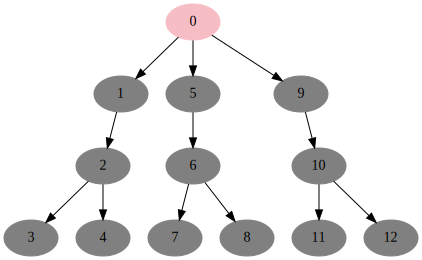

In [30]:
#Create demonstrations on small env


TREE = [[1,5,9], [2], [3,4], [], [], [6], [7,8], [], [], [10], [11,12], [], []]

r0 = Categorical([-4, -2, 2, 4])
r1 = Categorical([-96, -4, 4, 8], probs=[0.1, 0.3, 0.3, 0.3])
r2 = Categorical([-48, -24, 24, 48])

INIT = [r0, r0, r1, r2, r2, r0, r1, r2, r2, r0, r1, r2, r2]

mdp = MouselabVar(TREE, INIT, cost=1)
Q, V, pi, info = solve(mdp)
qs = {}
mdp._render()


In [31]:
start = time.time()
V(mdp._state)
print("Duration:", time.time() - start)

Duration: 1342.781378030777


In [32]:
def state_to_string(state):
    state_str = "0"
    for node in state[1:]:
        if hasattr(node, "sample"):
            state_str += " _"
        else:
            state_str += " " + str(node)
    return state_str

In [36]:
envs = []

for i in range(5):
    tmp_env = {}
    tmp_env["trial_id"] = str(i)
    np.random.seed(i)
    mdp = MouselabVar(TREE, INIT, cost = 1)
    truth = mdp.ground_truth
    tmp_env["stateRewards"] = list([int(x) for x in truth])
    envs.append(tmp_env)

'''
[array([  0,   2,   4,  24, -24,   2,   4,  48,  48,  -2,   8,  24,  24]),
 array([  0,   2, -96, -24, -48,  -4,  -4, -24, -24,   2,   4,  24, -48]),
 array([  0,  -4,   4, -24, -24,  -2,  -4,  24, -24,  -2,   4,  24, -48]),
 array([  0,   2,  -4,  24,  48,   4,  -4, -48, -48,  -2, -96, -24,  24]),
 array([  0,   2,   8,  24,  24,  -4,   8, -48, -24,  -2,   8, -48,  48])]
 '''

envs

[{'trial_id': '0',
  'stateRewards': [0, 2, 4, 24, -24, 2, 4, 48, 48, -2, 8, 24, 24]},
 {'trial_id': '1',
  'stateRewards': [0, 2, -96, -24, -48, -4, -4, -24, -24, 2, 4, 24, -48]},
 {'trial_id': '2',
  'stateRewards': [0, -4, 4, -24, -24, -2, -4, 24, -24, -2, 4, 24, -48]},
 {'trial_id': '3',
  'stateRewards': [0, 2, -4, 24, 48, 4, -4, -48, -48, -2, -96, -24, 24]},
 {'trial_id': '4',
  'stateRewards': [0, 2, 8, 24, 24, -4, 8, -48, -24, -2, 8, -48, 48]}]

In [37]:
def q_rec(state, truth):
    state_str = state_to_string(state)
    actions = list(mdp.actions(state))
    if len(actions) >= 1 and (state_str not in q_env.keys()):
        action_v = {}
        for a in actions: 
            action_v[str(a)] = round(float(Q(state, a)), 2)
            if a is not len(state): # not term action
                value = truth[a]
                next_state = tuple([state[i] if i is not a else value for i in range(len(state))])
                q_rec(next_state, truth)
        q_env[state_str] = action_v
        

feedback = {}
for env in envs:
    print(env["trial_id"])
    q_env = {}
    q_rec(mdp._state, env["stateRewards"])
    env["qs"] = q_env

0
1
2
3
4


In [38]:
with open("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/utils/Qvals.json", "w") as outfile:  
    json.dump(envs, outfile) 

In [18]:
def q_rec(state, truth):
    state_str = state_to_string(state)
    actions = list(mdp.actions(state))
    if len(actions) >= 1 and (state_str not in qs.keys()):
        action_v = {}
        for a in actions: 
            action_v[str(a)] = round(float(Q(state, a)), 2)
            if a is not len(state): # not term action
                value = truth[a]
                next_state = tuple([state[i] if i is not a else value for i in range(len(state))])
                q_rec(next_state, truth)
        qs[state_str] = action_v

qs = {}
for env in envs:
    print(env)
    q_rec(mdp._state, env)

[  0   2   4  24 -24   2   4  48  48  -2   8  24  24]
[  0   2 -96 -24 -48  -4  -4 -24 -24   2   4  24 -48]
[  0  -4   4 -24 -24  -2  -4  24 -24  -2   4  24 -48]
[  0   2  -4  24  48   4  -4 -48 -48  -2 -96 -24  24]
[  0   2   8  24  24  -4   8 -48 -24  -2   8 -48  48]


In [20]:
with open("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/utils/Qvals.json", "w") as outfile:  
    json.dump(qs, outfile) 